# European Derivatives Hedging in Multinomial Market Models


Consider the example of an investor hedging a European contingent claim $H$ in an arbitrage-free financial market of $d$ risky securities (and a risk-free bank account) and $T$ trading periods until the maturity of $H$.
We identify the securities with their price processes $P^{1},\dots, P^{d}$ which we assume to be non-negative stochastic processes on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$ adapted to a filtration $(\mathcal{G}_t)_{t=0}^T$. 
Write $P_t = (P^{1}_t, \dots, P^{d}_t)$ for all times $t$.
Additionally, $P^{(0)}$ refers to the bank account which at time $t$ shall accrue at the deterministic rate $r_t^{(0)} = \Delta P^{(0)}_t / P^{(0)}_{t-1} \in\mathbb{R}$.

We assume the price processes to have independent increments, meaning that for every risky security $P^i$ the process of its excess returns $(R^{(i)}_t)_{t=0}^T$, $$R^{i}_t = \Delta P^{i}_t / P^{i}_{t-1},\quad t=0,\dots, T,$$ as a family of random variables, is independent.
Write $R_t = (R^{1}_t, \dots, R^{d}_t)$ for all times $t$. 

The investor's self-financing hedging strategy reduces to an adapted process $A=(A_0,\dots, A_T)$ with positions $A_t = (A^{1}_t,\dots, A^{d}_t)$ in $\mathbb{R}^d$ indicating the net amounts invested into the market's risky securities at time $t$ together with an *initial wealth* $W_0$:
For the strategy to indeed be self-financing the associated *wealth process* $(W_t)$ given by $W_t=A^{(0)}_t + \sum_{i=1}^d A^{i}_t$, where $A^{(0)}_t$ is the investor's time-$t$ position in the money market account, must satisfy the condition $\Delta W_{t+1} = \langle (A^{(0)}_t,A_t), (r^{(0)}_{t+1}, R_{t+1})\rangle$ at all times $t$ which allows to recurse $$W_{t+1} = W_t + \langle A_t, R_{t+1}\rangle + \bigr(W_t - \sum_{i=1}^d A_t^{i}\bigr)r^{(0)}_{t+1},\quad t=0,\dots, T$$ in terms of the initial wealth $W_0$ and the process $A$.

It is the hedging investor's objective to expect to incur a minimal *square replication error* $|W_T - H|^2$.
If the claim $H$ is attainable, then the unique initial endowment $W_0$ for which the replication error is expected to vanish constitutes the fair price of the claim $H$ at time $0$.

Provided that $H$ factorizes with respect to the terminal market state, i.e. $H=h(P_T)$ for some Borel function $h$, we recognize this problem to be a Markovian stochastic optimal control problem.
Because of the independent excess returns, the state relevant to the investor at each time $t$ is limited the current wealth $w_t$ of his portfolio together with the current market prices $p_t$, i.e. $s_t = (w_t, p_t)$. 
The investor controls the next state $s_{t+1}$ through his investments $a_t$ into the risky assets: $S_{T+1}  = F_t(S_t, A_t, R_{t+1})$ with $$F_t(s_t, a_t, r_{t+1}) = \left(w_t + \langle a_t, r_{t+1}\rangle + (w_t - \textstyle\sum_{i=1}^d a_t^i) r^{(0)}_{t+1},\; (1 + r_{t+1}) p_t\right),\quad s_t=(w_t,p_t)\in\mathbb{R}^{1+d},\quad a_t, r_{t+1}\in\mathbb{R}^d.$$ 

Setting $k_0,\dots, k_{T-1}$ to zero and $$k_T(s_T, a_T) = |h(p_T) - w_T|$$ we find that an optimal control for a such defined problem evaluates, in the investor's context, to a perfect hedge.


## Imports

We have seen in the above that the optimal control problem lies in the scope of `ml_adp`.
We import packages to solve the optimal control problem using `ml_adp`:

In [14]:
from ml_adp.cost import CostToGo
from ml_adp.model.finance import MarketStep, SquareReplicationError

Additional packages we will touch:

In [15]:
import torch  # Fundamental
import matplotlib.pyplot as plt  # Plotting
import copy  # Compare different algorithms starting with equal initial models
from tqdm import tqdm  # Progress bars for the optimization loops

## Device Settings

Enable GPU acceleration of the numerical simulation, if available.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Model Implementation

As a concrete example take

* the financial market to have $5$ trading periods and consist of a single risky asset trading at a current level of $100$: $T=5$, $d=1$ and $P_0 = 100$ (setting $P=P^{(1)}$ and $R=R^{(1)}$)
* A multinomial model for the securities returns: $R_0,\dots, R_T$ i.i.d. with law $$\mathbb{P}_{R_t} = 3/10*\delta_{\{-0.05\}} + 1/10*\delta_{\{0\}} + 6/10 * \delta_{\{0.05\}}$$
* The locally risk-free asset yielding nothing: $R_t^{(0)} = 0$ for all times $t$
* $H$ an European call option on $S$ with maturity $T=5$ and strike equal to the initial price of $S$: $$H = (S_5 - 100)^+.$$

Fix the basic parameters:

In [17]:
time_horizon = 6
number_risky_assets = 1

initial_value = torch.tensor([100.]).to(device)
risk_free_rate = torch.tensor([0.]).to(device)

rets = torch.tensor([0.05, -0.05, 0.0]).to(device)
probs = torch.tensor([0.6, 0.3, 0.1]).to(device)

We begin by creating an empty `CostToGo` of appropriate length:

In [60]:
square_replication_error = CostToGo.from_steps(time_horizon)

square_replication_error

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                   None         
    1           None                   None                   None         
    2           None                   None                   None         
    3           None                   None                   None         
    4           None                   None                   None         
    5           None                   None                   None         
    6           None                   None                   None         
   (7)          None                                                       
)

We need to provide `square_replication_error` with an implementation of the state transition function and the cost function.
We begin by implementing the state transition function $F(s_t, a_t, \xi_{t+1})$ (keeping in mind the existence of the batch axis).
We make it save the risk-free rate $r^{(0)}$ as an instance attribute.

In [56]:
class MarketStep:
    def __init__(self, risk_free_rate: float = 0.0) -> None:
        self.risk_free_rate = risk_free_rate
    
    def __call__(self, state: torch.Tensor, position: torch.Tensor, excess_returns: torch.Tensor) -> torch.Tensor:
        wealth = state[..., [0]]
        prices = state[..., 1:]

        net_amount = position.sum(dim=-1, keepdim=True)
        bank_account = wealth - net_amount

        change_w = (bank_account * self.risk_free_rate
                    + torch.einsum('...j,...j->...', position, excess_returns).unsqueeze(1))
        change_p = prices * excess_returns

        return torch.cat([wealth + change_w, prices + change_p], dim=1) 

Intermittently, provide `square_replication_error` with `MarketStep`'s:

In [61]:
square_replication_error.state_functions[:-1] = MarketStep(risk_free_rate)

square_replication_error

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                   None         
    1      MarketStep(-)               None                   None         
    2      MarketStep(-)               None                   None         
    3      MarketStep(-)               None                   None         
    4      MarketStep(-)               None                   None         
    5      MarketStep(-)               None                   None         
    6      MarketStep(-)               None                   None         
   (7)          None                                                       
)

Next, implement the cost function $k_T(s_T, a_T) = \vert h(p_T) - w_T\vert^2$.
We modularize the design and consider the payoff function $h$ as a separate component, turning first to the actual cost function that will accept the payoff function during construction:

In [57]:
from abc import abstractmethod
from collections.abc import Callable

class Derivative(Callable):
    r"""Implements Payoff Functions $h(p_T)$"""
    @abstractmethod
    def __call__(self, prices: torch.Tensor) -> torch.Tensor:
        return


class SquareReplicationError:
    r"""Given Payoff Function $h(p_T)$, Implements Square Replication Error $|w_T - h(p_T)|"""
    def __init__(self, derivative: Derivative) -> None:
        self.derivative = derivative
    
    def __call__(self, state: torch.Tensor, position: torch.Tensor=None) -> torch.Tensor:
        wealth = state[..., [0]]
        prices = state[..., 1:]
        payoff = self.derivative(prices)
        return (payoff - wealth).square()

Next, we implement a generic European call option payoff function $h(p_T) = (p_T - K)^+$ which we will instantiate with our example's values:

In [ ]:
class EuropeanCallOption(Derivative):
    def __init__(self, strike: float, underlying_index: int) -> None:
        super().__init__()
        self.strike = strike
        self.underlying_index = underlying_index
    
    def __call__(self, prices: torch.Tensor) -> torch.Tensor:
        underlying_price = prices[..., [self.underlying_index]]
        option_payoff = torch.maximum(
            underlying_price - self.strike,
            torch.tensor(0.0)
        )
        return option_payoff

The user can find all the classes whose definition – for the sake of exposition – we just printed in full in the submodule `ml_adp.model.finance`.

Combine everything and create the `CostToGo`

In [62]:
option = EuropeanCallOption(strike=100., underlying_index=0)
square_replication_error.cost_functions[-1] = SquareReplicationError(option)

Inspect the `square_replication_error`. 
At this point, it is only missing some neural network based control functions.

In [63]:
square_replication_error

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                   None         
    1      MarketStep(-)               None                   None         
    2      MarketStep(-)               None                   None         
    3      MarketStep(-)               None                   None         
    4      MarketStep(-)               None                   None         
    5      MarketStep(-)               None                   None         
    6      MarketStep(-)               None             SquareRe...or(-)   
   (7)          None                                                       
)

Last, but not least, we need to implement a sampler for the random effects which, in the present case, are the excess returns which are i.i.d. with multinomial law given by `rets` and `probs`.
We thus expose the sampler in terms of the sample size and the number of market steps we want to sample the excess returns for.
Additionally, we include some integration methods we will need later on when implementing the analytic solution of the heding problem.

In [ ]:
from torch.distributions.categorical import Categorical

class MultinomialDistribution:
    def __init__(self, rets: torch.Tensor, probs: torch.Tensor):
        self.rets = rets
        self.probs = probs
        self.categorical = Categorical(probs)
    
    def __repr__(self):
        return "MultinomialDistribution(" + "+ ".join([f"{prob: .2f}xδ{{{ret : .2f}}} " for ret, prob in zip(self.rets, self.probs)]) + ")"
    
    def sample(self, sample_size: int, steps: int) -> torch.Tensor:
        return self.rets[self.categorical.sample([steps, sample_size, 1])]
        
    def integrate(self, integrand: torch.Tensor, moment: int = 0):
        return torch.sum(integrand.squeeze(-1) * (self.rets ** moment) * self.probs, dim=-1, keepdim=True)
   
    def mean(self):
        return self.integrate(torch.tensor(1.), moment=1)
    
    def second(self):
        return self.integrate(torch.tensor(1.), moment=2)


md = MultinomialDistribution(rets, probs)

## Implementation of the Analytic Solution

For benchmarking purposes, we create another `CostToGo` based on the analytical solution of the problem.
The time-$t$ cost-to-go, as per the analytical solution given in [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3) and derived in [Bertsemas et al.](https://doi.org/10.1287/opre.49.3.372.11218), is $$V_t(s) = K_t w^2 + 2B_t(p)w + C_t(p), \quad s=(w, p)\in\mathbb{R}\times\mathbb{R}$$ where, backward-recursively, with $m_{1, t} = E_{\mathbb{P}}R_t$ and $m_{2, t} = E_{\mathbb{P}}(R_t^2)$, $$K_t = K_{t+1}(1 - ER_{t+1}E(R^2_{t+1})),\quad t=T-1,\dots, 0$$ and $$B_t(p) = E_{\mathbb{P}}B_{t+1}(p(1 + R_{t+1})) - \frac{m_{1,t+1}}{m_{2, t+1}} E_{\mathbb{P}}(B_{t+1}(p(1+R_{t+1}))R_{t+1}), \quad p\in\mathbb{R},\quad t=T-1,\dots, 0$$ and $$C_t(p) = E_{\mathbb{P}}C_{t+1}(p(1 + R_{t+1})) - \frac{\bigr(E_{\mathbb{P}}\big(B_{t+1}(p(1+R_{t+1}))R_{t+1}\big)\bigr)^2}{K_{t+1}\, m_{2,t+1}} ,\quad p\in\mathbb{R}, \quad t=T-1,\dots, 0,$$ based on $$K_T = 1, \quad B_T = h,\quad C_T = h^2.$$

Accordingly (and inefficiently sans memoization):

In [64]:
def K(time: int, time_horizon: int, md: MultinomialDistribution) -> torch.Tensor:
    return (1. - (md.mean() / md.second()) * md.mean()) ** (time_horizon - time)

def B(prices: torch.Tensor, time: int, time_horizon: int, option: Derivative, md: MultinomialDistribution) -> torch.Tensor:
    if time == time_horizon:
        return option(prices)
    else:
        next_prices = (prices * (1. + md.rets.unsqueeze(0))).unsqueeze(-1)
        b0 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=0)
        b1 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=1)
        return b0 - (md.mean() * b1) / md.second()

def C(prices: torch.Tensor, time: int, time_horizon: int, option: Derivative, md: MultinomialDistribution) -> torch.Tensor:
    if time == time_horizon:
        return option(prices) ** 2
    else:
        next_prices = (prices * (1. + md.rets.unsqueeze(0))).unsqueeze(-1)
        c0 = md.integrate(C(next_prices, time+1, time_horizon, option, md), moment=0)
        b1 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=1)
        return c0 - (b1 / K(time+1, time_horizon, md)) * (b1 / md.second())

In [23]:
import functools as ft

k = ft.partial(K, time=0, time_horizon=time_horizon, md=md)
b = ft.partial(B, time=0, time_horizon=time_horizon, option=option, md=md)
c = ft.partial(C, time=0, time_horizon=time_horizon, option=option, md=md)

def v0(state: torch.Tensor):
    wealth = state[:, [0]]
    prices = state[:, 1:]
    
    return k() * (wealth ** 2) - 2 * b(prices) * wealth + c(prices)

analytic_error = CostToGo.from_steps(0)
analytic_error.cost_functions[0] = v0

Inspect the analytic solution for different initial price values; the location $B_0(p_0)/K_0$ of the minimum $V_0^* = 0$ of the cost-to-go graphs represents – for attainable claims – the fair price of the derivative at time $0$.
In our example, at the given initial price value of $100$, the price of the given European call option evaluates to:

In [24]:
b(initial_value) / k()

tensor([[4.6183]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1308a9990>],
      dtype=object)

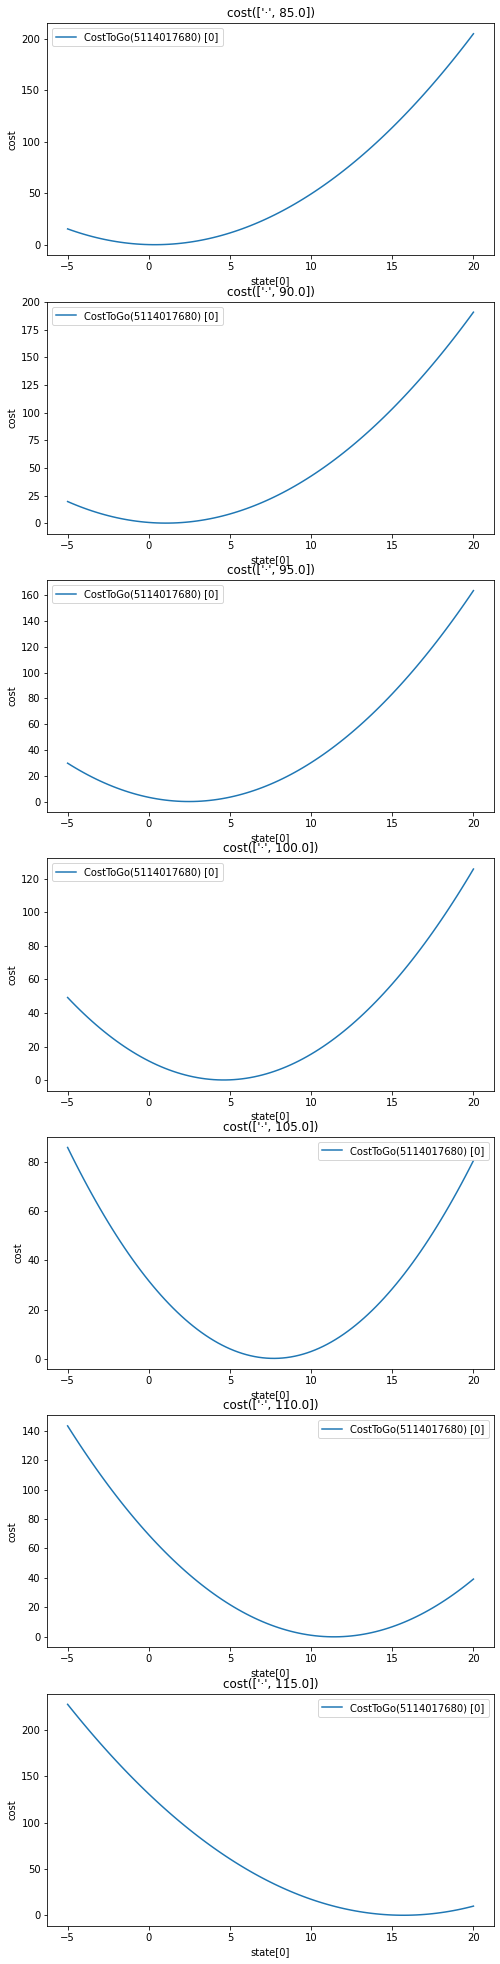

In [25]:
analytic_error.plot_state_component_range(
    torch.arange(-5., 20.25, 0.25).to(device),
    torch.arange(85., 116., 5.).to(device),
    plot_size=(8,5)
)

## Control Function Specification

We are at the point at which the neural networks to be used for the control functions must be specified.
This, generally, is an exercise of the domain expert.
A such will be informed (by e.g. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that, in the given situation, the optimal control at each step will depend linearly on the current wealth level and that the current market price levels parametrize these linear dependencies.
`ml_adp.mapping.linear.LinearMap` implements learnable such parametrized linear maps by relying on an FFN to parametrize a linear transformation representation matrix.


In [26]:
from ml_adp.mapping.linear import LinearMap
from typing import Sequence

class LinearStrat(torch.nn.Module):
    """
    Have an FFN parametrize a linear insertion (of the wealth 
    into the control space) with (d x 1)-representation matrix 
    """
    def __init__(self, hidden_layer_sizes: Sequence[int], **ffn_config):
        super().__init__()
        ffn_config.update({
            'size': (number_risky_assets, *hidden_layer_sizes, (number_risky_assets, 1)),
            'hidden_activation': torch.nn.ELU()
        })
        self.linear_map = LinearMap.from_ffnconfig(**ffn_config)

    def forward(self, state):
        wealth = state[:, [0]]
        prices = state[:, 1:]
        return self.linear_map(wealth, prices)

Set the control functions; the following configuration has been identified to work well for the controls of this particular instance of the option hedging problem:

In [27]:
hidden_layer_sizes = (55, 55)

for time in range(len(square_replication_error) - 1):  # Do not need a control at maturity
    square_replication_error.control_functions[time] = LinearStrat(hidden_layer_sizes)

Inspect ``square_replication_error`` and sanity-check its representation:

In [28]:
square_replication_error

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                           LinearStrat(train)            None         
    1      MarketStep(-)        LinearStrat(train)            None         
    2      MarketStep(-)        LinearStrat(train)            None         
    3      MarketStep(-)        LinearStrat(train)            None         
    4      MarketStep(-)        LinearStrat(train)            None         
    5      MarketStep(-)        LinearStrat(train)            None         
    6      MarketStep(-)               None             SquareRe...or(-)   
   (7)          None                                                       
)

## Choosing the Training Distributions

For the training distributions, the domain expert defaults to a normal distribution that for the wealths has ~ 68% of its mass contained in the interval $[0, 10]$ and is centered at $5$ (which is a reasonable estimate for the price of the option) and chooses, for the prices, again a normal distribution centered at the initial price $100$ and with the standard deviation increasing based on the number of trading periods into the market (reflecting his expectation of the distribution of the prices to get flatter with time).

In [29]:
from torch.distributions.multivariate_normal import MultivariateNormal

class TrainingStateSampler:
    def __init__(self, time: int):
        loc = torch.tensor([5., initial_value]).to(device)
        covariance = torch.diag(torch.tensor([10. ** 2, (3. * max(time, 1)) ** 2])).to(device)
        self.sampler = MultivariateNormal(loc, covariance_matrix=covariance)
    
    def __call__(self, sims_size: int):
        return self.sampler.sample((sims_size,))

Create a dictionary containing all the relevant components:

In [30]:
model = {
    'cost_to_go': square_replication_error,
    'training_state_samplers': [TrainingStateSampler(time) for time in range(len(square_replication_error))],
    'random_effects_samplers': len(square_replication_error) * [md]
}

## NNContPi

Create a fresh copy of the model and extract the components:

In [31]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
training_state_samplers = model['training_state_samplers']
random_effects_samplers = model['random_effects_samplers']


The following optimization hyperparameters have proven themselves to work well:

In [49]:
gradient_descent_steps = 350 

optimizer_class = torch.optim.Adam
lr = 0.044

scheduler_class = torch.optim.lr_scheduler.ExponentialLR
gamma = 0.75

Choose the sample size for the Monte-Carlo simulation:

In [50]:
sims_size = 10000  # Monte-Carlo Simulation Size

Perform the NNContPi optimization routine:

In [51]:
print("Optimizing the following model using NNContPi-Algorithm:")
print(cost_to_go.__repr__())

cost_to_go.train()

for time in reversed(range(len(cost_to_go) - 1)):
    
    objective = cost_to_go[time:]
    training_state_sampler = training_state_samplers[time]
    random_effects_sampler = random_effects_samplers[time]

    optimizer = optimizer_class(objective.control_functions[0].parameters(), lr=lr)
    scheduler = scheduler_class(optimizer, gamma=gamma)

    gradient_descent_iterations = tqdm(range(gradient_descent_steps))
    for iteration in gradient_descent_iterations:

        training_state = training_state_sampler(sims_size)
        rand_effs = random_effects_sampler.sample(sims_size, objective.steps())

        cost = objective(training_state, rand_effs).mean()
        
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if iteration % 30 == 0 and iteration > 0:
            scheduler.step()

        gradient_descent_iterations.set_description(
            f"Time {time} Control Optimization - `cost_to_go[{time}:]`-Cost: {cost:9.4f}"
        )
    
    objective.eval()

Optimizing the following model using NNContPi-Algorithm:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                           LinearStrat(train)            None         
    1      MarketStep(-)        LinearStrat(train)            None         
    2      MarketStep(-)        LinearStrat(train)            None         
    3      MarketStep(-)        LinearStrat(train)            None         
    4      MarketStep(-)        LinearStrat(train)            None         
    5      MarketStep(-)        LinearStrat(train)            None         
    6      MarketStep(-)               None             SquareRe...or(-)   
   (7)          None                                                       
)


Time 5 Control Optimization - `cost_to_go[5:]`-Cost:  155.7223: 100%|██████████| 350/350 [00:24<00:00, 14.36it/s]
Time 4 Control Optimization - `cost_to_go[4:]`-Cost:  117.9790: 100%|██████████| 350/350 [00:35<00:00,  9.77it/s]
Time 3 Control Optimization - `cost_to_go[3:]`-Cost:   90.8442: 100%|██████████| 350/350 [00:55<00:00,  6.33it/s]
Time 2 Control Optimization - `cost_to_go[2:]`-Cost:   71.4217: 100%|██████████| 350/350 [01:05<00:00,  5.37it/s]
Time 1 Control Optimization - `cost_to_go[1:]`-Cost:   58.8546: 100%|██████████| 350/350 [01:13<00:00,  4.74it/s]
Time 0 Control Optimization - `cost_to_go[0:]`-Cost:   60.5292: 100%|██████████| 350/350 [01:36<00:00,  3.63it/s]


Note that the time required for each gadient descent iteration increases as the backward pass advances.

Plot the expected square replication errors as implied by `cost_to_go` and the analytical solution against the initial wealth.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131749e10>],
      dtype=object)

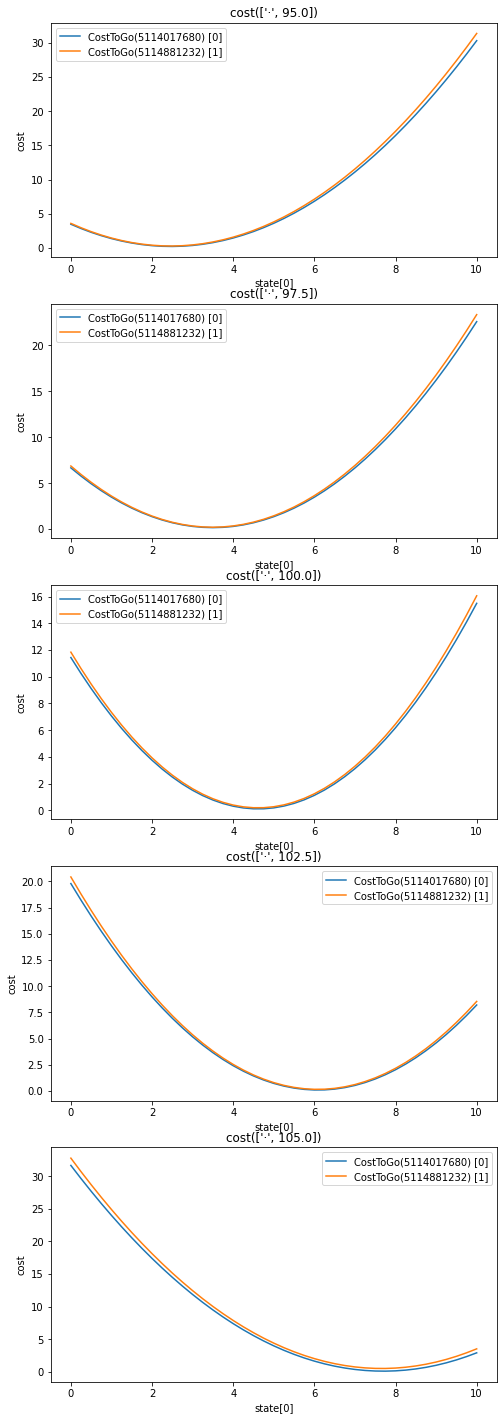

In [52]:
rand_effs = random_effects_samplers[-1].sample(10000, cost_to_go.steps())

analytic_error.plot_state_component_range(
    torch.arange(0, 10.25, 0.25).to(device),
    torch.arange(95., 107.5, 2.5).to(device), 
    random_effects=rand_effs,
    versus=cost_to_go,
    plot_size=(8,5)
)

Approximately infer from the orange line the fair price of $4.6$ (for the initial price of $100$) for the option and compare the analytical solution (orange).

## HybridNow

We start anew:

In [ ]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
training_state_samplers = model['training_state_samplers']
random_effects_samplers = model['random_effects_samplers']

We perform the optimization using the HybridNow algorithm (cf. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that includes value function approximation at each of the optimization steps of the above algorithm, ensuring a constant run-time for each of the backward iteration steps.
The domain expert will notice that the convexity of the cost function in the wealth-level translates to the convexity of the expected total cost in the wealth.
They decide to apply *partially input-convex neural networks* (as introduced in [arXiv:1609.07152v3](https://arxiv.org/abs/1609.07152v3) and implemented by `ml_adp.mapping.convex.PICNN`) for value function approximation because they expect a neural network with the right convexity properties backed into the architecture to begin with to lead to a more efficient traversal of the solution space:

In [37]:
from ml_adp.mapping.convex import PICNN

class PICNNVal(torch.nn.Module):
    def __init__(self, output_net_hidden_sizes: Sequence[int], param_net_hidden_sizes: Sequence[int]):
        super().__init__()

        picnn_config = {        
            'output_net_size': (1, *(output_net_hidden_sizes), 1),
            'param_net_size': (1, *(param_net_hidden_sizes), 1),
            'output_net_hidden_activation': torch.nn.ELU(),

            'param_net_config': {
                'hidden_activation': torch.nn.ELU()
            }
        }

        self.picnn = PICNN(**picnn_config)

    def forward(self, states):
        wealth = states[:, [0]]
        prices = states[:, 1:]
        return self.picnn(wealth, prices)

The following configurations have proven themselves to work well for the optimal control problem at hand:

In [38]:
output_net_hidden_sizes = (60, 60)
param_net_hidden_sizes = (100, 100)

Choose the optimization hyperparameters for the value function approximation:

In [39]:
approximation_gradient_descent_steps = 150
approximation_batch_size = 50

approximation_optimizer_class = torch.optim.Adam

approximation_output_net_lr = 5e-2
approximation_param_net_lr = 5e-2

gamma = 0.9

Perform the HybridNow optimization procedure:

In [40]:
from torch.distributions.uniform import Uniform

wealth_sampler = Uniform(-25, 25)
price_sampler = Uniform(70, 130)

def approximation_training_state_sampler(sims_size: int):
    wealths = wealth_sampler.sample((sims_size, 1))
    prices = price_sampler.sample((sims_size, 1))
    
    return torch.cat([wealths, prices], dim=1)

In [ ]:
print("Optimizing the following model using Hybrid-Algorithm:")
print(cost_to_go.__repr__(include_id=True))

cost_to_go.eval()

cost_approximators = [None] * len(cost_to_go)  # Create cost approximators on the fly and save in this list
cost_approximators[-1] = cost_to_go[-1]  # Exact

for time in reversed(range(len(cost_to_go) - 1)):
    
    objective = cost_to_go[time] + cost_approximators[time + 1]
    training_state_sampler = training_state_samplers[time]
    random_effects_sampler = random_effects_samplers[time]

    # Control Optimization:
    objective.control_functions[0].train()    
    optimizer = optimizer_class(objective.control_functions[0].parameters(), lr=lr)

    optimization_iterations = tqdm(range(gradient_descent_steps))
    for _ in optimization_iterations:
        
        rand_effs = random_effects_sampler.sample(sims_size, objective.steps())
        training_state = training_state_sampler(sims_size)
        
        cost = objective(training_state, rand_effs).mean()
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        optimization_iterations.set_description(
            f"Time {time} Control Optimization - `cost_to_go[{time}:]`-Cost: {cost:9.4f}"
        )
    objective.eval()

    # Cost Function Approximation:
    cost_approximator = CostToGo.from_steps(0)
    cost_approximator.cost_functions[0] = PICNNVal(output_net_hidden_sizes, param_net_hidden_sizes)
    cost_approximator.to(device)
    
    cost_approximators[time] = cost_approximator
    
    optimizer = approximation_optimizer_class(
        params=cost_approximator.cost_functions[0].picnn.output_net_modules.parameters(), 
        lr=approximation_output_net_lr
    )
    optimizer.add_param_group({
        'params': cost_approximator.cost_functions[0].picnn.param_net_modules.parameters(),
        'lr': approximation_param_net_lr
    })
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    approximation_iterations = tqdm(range(approximation_gradient_descent_steps))
    for iteration in approximation_iterations: 
        
        training_state = approximation_training_state_sampler(approximation_batch_size)
        rand_effs = random_effects_sampler.sample(sims_size, objective.steps())
        
        with torch.no_grad():
            cost = torch.stack([objective(state, rand_effs).mean(dim=0) 
                                for state in training_state], dim=0)
        approx_cost = cost_approximator(training_state)
        approx_error = torch.norm(cost - approx_cost, p=2)
        
        approx_error.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if iteration % 100 == 0 and iteration >= 1:
            scheduler.step()
        
        approximation_iterations.set_description(
            f"Time {time} Value Function Approximation - Error: {approx_error:9.2f}"
        )
    cost_approximator.eval()

    with torch.no_grad():
        cost_approximator.plot_state_component_range(
            torch.arange(-10., 10.5, 0.5).to(device),
            torch.arange(97., 104.).to(device),
            random_effects=rand_effs,
            versus=objective,
            plot_size=(8,5)
        )
        plt.show()

Compare the time-$0$ cost approximator, ``cost_to_go`` with its controls optimized by the Hybrid-Now procedure, and the analytic solution:

In [ ]:
analytic_error.plot_state_component_range(
    torch.arange(0., 10.5, 0.25).to(device),
    torch.arange(100., 101.).to(device),
    random_effects=rand_effs,
    versus=[cost_to_go, cost_approximator[0]],
    plot_size=(8,5)
)
plt.show()